In [1]:
# package(s) related to time, space and id
import os
import json

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style
from osgeo import ogr, osr

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt     

# Used for making the graph to visualize our problem
import networkx as nx  

# Graph location
location_graph = "Vaarwegvakken"
name_graph = "Vaarwegvakken.shp"
name_graph_conv = "Vaarwegvakken - wgs84.shp"

### Check information in graph

In [2]:
# Read the shape-file
FG = nx.read_shp(os.path.join(location_graph, name_graph), 
                 simplify=True)

In [3]:
for i, node in enumerate(FG.nodes(data = True)):
    print(node)
    break

((38358.0, 394007.0), {})


In [4]:
for i, edge in enumerate(FG.edges(data = True)):
    print(edge)
    break

((38358.0, 394007.0), (37786.0, 393803.0), {'VWK_ID': 2069, 'VWK_BEGDTM': '1998/01/01', 'VWJ_ID_BEG': 1721, 'VWJ_ID_END': 1708, 'VAKTYPE': 'D', 'VRT_CODE': '135', 'VRT_NAAM': 'Zandkreek en Veerse Meer', 'VWG_NR': 1, 'VWG_NAAM': 'Veerse Meer', 'BEGKM': 17.856, 'ENDKM': 18.483, 'ShpName': 'Vaarwegvakken', 'Wkb': b'\x00\x00\x00\x00\x02\x00\x00\x00\x06@\xe2\xba\xc0\x00\x00\x00\x00A\x18\x0c\\\x00\x00\x00\x00@\xe2\x9c\x80\x00\x00\x00\x00A\x18\n\x10\x00\x00\x00\x00@\xe2\x95\x00\x00\x00\x00\x00A\x18\tx\x00\x00\x00\x00@\xe2\x8a\xe0\x00\x00\x00\x00A\x18\t0\x00\x00\x00\x00@\xe2x\x80\x00\x00\x00\x00A\x18\t\x14\x00\x00\x00\x00@\xe2s@\x00\x00\x00\x00A\x18\t,\x00\x00\x00\x00', 'Wkt': 'LINESTRING (38358 394007,38116 393860,38056 393822,37975 393804,37828 393797,37786 393803)', 'Json': '{ "type": "LineString", "coordinates": [ [ 38358.0, 394007.0 ], [ 38116.0, 393860.0 ], [ 38056.0, 393822.0 ], [ 37975.0, 393804.0 ], [ 37828.0, 393797.0 ], [ 37786.0, 393803.0 ] ] }'})


### Convert graph to lat-long

In [5]:
def transform_projection(location_graph, name_graph):
    driver = ogr.GetDriverByName("ESRI Shapefile")
    dataset = driver.Open(os.path.join(location_graph, name_graph))

    # from Layer
    inSpatialRef = dataset.GetLayer().GetSpatialRef()

    # Set up the coordinate reference we want to use, WGS84 - World Geodetic System 1984
    outSpatialRef = osr.SpatialReference()
    outSpatialRef.ImportFromEPSG(4326)

    # Transform the coordinates
    transform = osr.CoordinateTransformation(inSpatialRef, outSpatialRef)
    
    return transform

In [6]:
def change_projection(transform, point):
    point = ogr.CreateGeometryFromWkt(str(point))
    
    point.Transform(transform)
    point.ExportToWkt()
    
    return point.GetX(), point.GetY()

In [7]:
transform = transform_projection(location_graph, name_graph)
FG_new = nx.DiGraph()

nodes_dict = {}

for i, node in enumerate(FG.nodes(data = True)):
    coordinates = change_projection(transform, shapely.geometry.Point(list(FG.nodes)[i][0], list(FG.nodes)[i][1]))
    name = "({:f}, {:f})".format(coordinates[0], coordinates[1])
    geometry = shapely.geometry.Point(coordinates[0], coordinates[1])
    
    nodes_dict[list(FG.nodes)[i]] = name
    FG_new.add_node(name, Name = name, Position = coordinates, Geometry = geometry, Old = node[1])
    
for edge in FG.edges(data = True):
    node_1 = nodes_dict[edge[0]]
    node_2 = nodes_dict[edge[1]]
    
    VRT_NAAM = edge[2]["VRT_NAAM"]
    VWG_NAAM = edge[2]["VWG_NAAM"]
    BEGKM =  edge[2]["BEGKM"]
    ENDKM =  edge[2]["ENDKM"]
    DIST = np.abs(float(BEGKM) - float(ENDKM))
    
    LINE = (json.loads(edge[2]["Json"])["coordinates"])
    LineString = []
    for coordinates in LINE:
        LineString.append(change_projection(transform, shapely.geometry.Point(coordinates[0], coordinates[1])))
    
    FG_new.add_edge(node_1, node_2, LineString = shapely.geometry.LineString(LineString), 
                    VRT_NAAM = VRT_NAAM, VWG_NAAM = VWG_NAAM, BEGKM = BEGKM, ENDKM = ENDKM, DIST = DIST)

if nx.info(FG) == nx.info(FG_new):
    print("Succes!")

Succes!


In [8]:
print("Nodes:", len(list(FG_new.nodes)))
print("Edges:", len(list(FG_new.edges)))

Nodes: 3336
Edges: 3712


### Plot graph

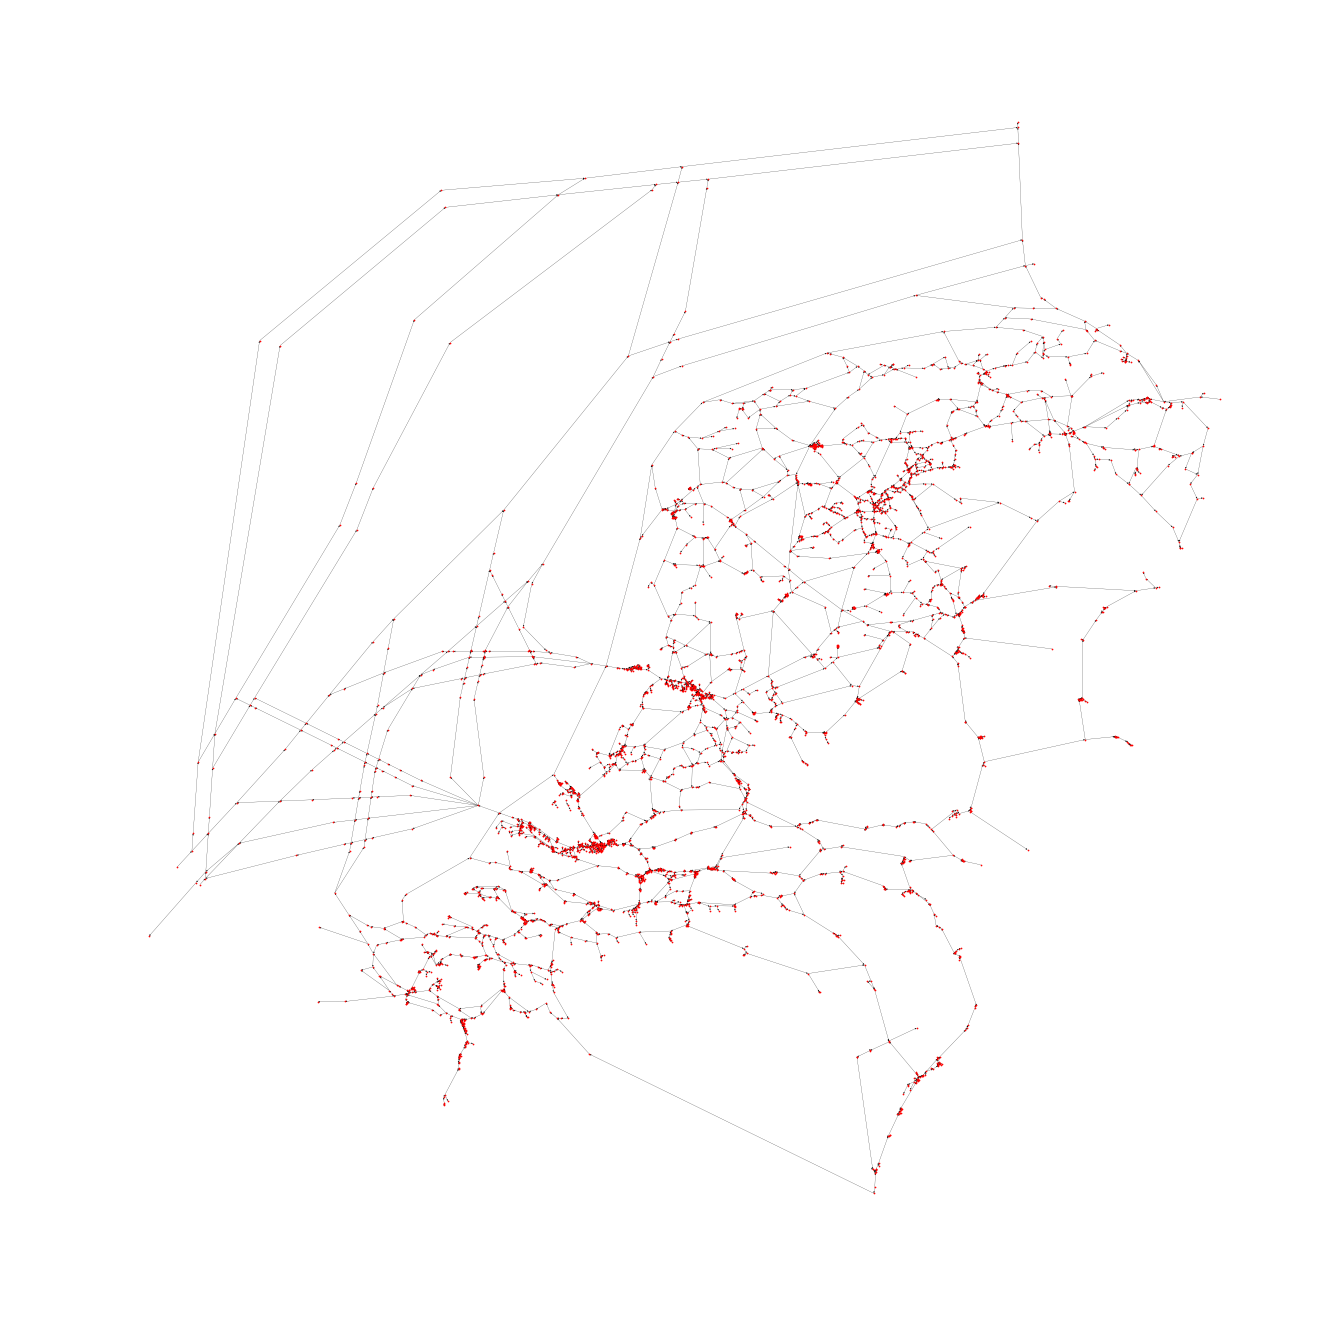

In [9]:
plt.figure(figsize=(18,18))
nx.draw(FG_new, nx.get_node_attributes(FG_new, 'Position'), node_size=0.5, font_size = 2, width = 0.2, arrowsize = 3)
plt.show()

In [18]:
for edge in FG_new.edges(data = True):
    line = edge[2]["LineString"]
    dist = edge[2]["DIST"]
    
    break

In [19]:
line.length

0.008522297516809304

In [20]:
dist

0.6269999999999989

In [25]:
for i in list(line.coords):
    print(i[0])
    break

3.7064154075981963


In [31]:
import pyproj
distance = 0

wgs84 = pyproj.Geod(ellps='WGS84')

for i, coord in enumerate(list(line.coords)):
    if i != (len(list(line.coords)) - 1):
        point_1 = shapely.geometry.Point((list(line.coords)[i][0], list(line.coords)[i][1]))
        point_2 = shapely.geometry.Point((list(line.coords)[i + 1][0], list(line.coords)[i + 1][1]))

        distance += wgs84.inv(shapely.geometry.asShape(point_1).x, shapely.geometry.asShape(point_1).y, 
                              shapely.geometry.asShape(point_2).x, shapely.geometry.asShape(point_2).y)[2]

print(distance)
print(dist*1000)

626.7233421914189
626.9999999999989


### Save to kml

In [27]:
# create a kml file containing the visualisation
kml = Kml()
fol = kml.newfolder(name="Graph")

shared_style = Style()
shared_style.labelstyle.color = 'ffffffff'  # White
shared_style.labelstyle.scale = 5  
shared_style.iconstyle.color = 'ffffffff'  # White
shared_style.iconstyle.scale = 0.5
shared_style.iconstyle.icon.href = "http://maps.google.com/mapfiles/kml/shapes/donut.png"
shared_style.linestyle.color = 'ff0055ff'  # Red
shared_style.linestyle.width = 0.5


for edge in FG_new.edges(data = True):
    
    # The points on the graph
    start_x = FG_new.nodes[edge[0]]["Geometry"].x
    start_y = FG_new.nodes[edge[0]]["Geometry"].y
    end_x = FG_new.nodes[edge[1]]["Geometry"].x
    end_y = FG_new.nodes[edge[1]]["Geometry"].y
    
    pnt = fol.newpoint(name='', coords=[(start_x, start_y)])
    pnt.style = shared_style
    pnt = fol.newpoint(name='', coords=[(end_x, end_y)])
    pnt.style = shared_style
    
    
    # The edges as lines based on the LineString attribute
    points_x = list(edge[2]["LineString"].coords.xy[0])
    points_y = list(edge[2]["LineString"].coords.xy[1])

    coords = []
    for i, _ in enumerate(points_x):
        coords.append((points_x[i], points_y[i]))

    lne = fol.newlinestring(name='', coords = coords)
    lne.style = shared_style

kml.save("Graph.kml")